<a href="https://colab.research.google.com/github/ChJazhiel/HPC_II/blob/main/Taller%20GANs/DCGAN_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

Objetivo: Generar dígitos escritos a mano con una Red Generativa Adversaria Convolucional (DCGAN)

In [1]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import imageio
import glob
from IPython import display
from tqdm.auto import tqdm # Loading bar

# Importar paquetes de pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Importar paquetes de  torchvision packages
from torchvision import datasets
from torchvision import transforms

## 1. Descargar el conjunto de datos y visualizar imágenes
1. Descargar el conjunto de datos.
2. Exploración del conjunto de datos.

In [2]:
mnist = datasets.MNIST(root='./data', # Ruta donde se almacena el conjunto de datos
                       train=True,    # Especifica si el conjunto de datos es de entrenamiento o prueba
                       download=True, # Descarga el conjunto de datos de internet si no está en la ruta
                       transform = transforms.Compose([transforms.ToTensor(),#, # Transformar las imágenes a tensores
                                                       transforms.Normalize([0.5],[0.5])])) # Reescalar imágenes en el rango [0,1] a [-1,1]

100%|██████████| 9912422/9912422 [00:00<00:00, 86410659.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4246352.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25536573.32it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 949961.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Exploración del conjunto de datos

In [3]:
# Obtener un elemento del conjunto de datos
img, _ = mnist[0]
print(f"Tamaño de la imagen: {img.shape}")  # Channels First  (NCHW)

Tamaño de la imagen: torch.Size([1, 28, 28])


In [4]:
print(f"Valor máximo del tensor: {img.max()}")
print(f"Valor mínimo del tensor: {img.min()}")

Valor máximo del tensor: 1.0
Valor mínimo del tensor: -1.0


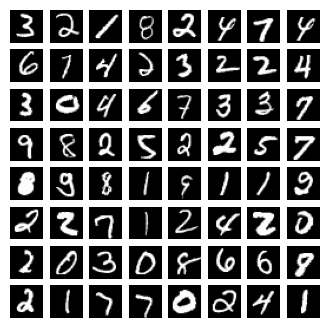

In [5]:
# Visualizar conjunto de datos
fig = plt.figure(figsize=(4,4))
rows, cols = 8, 8
for i in range(1,rows*cols+1):
    random_idx = random.randint(0, len(mnist))
    img, _ = mnist[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis("off")

## 2. Preparación del Data Loader  

In [6]:
BATCH_SIZE = 128
train_dataloader = DataLoader(dataset = mnist, # Conjunto de datos que se va a iterar
                               batch_size = BATCH_SIZE,# Cantidad de muestras contenidas en un batch
                               shuffle = True) # Los datos se revuelven después de iterar sobre todos los batches

In [7]:
print(f"Número de batches en el train loader: {len(train_dataloader)} batches de {BATCH_SIZE} imágenes cada uno")

Número de batches en el train loader: 469 batches de 128 imágenes cada uno


In [8]:
# Verificar que hay dentro del DataLoader
train_batches, _ = next(iter(train_dataloader))
print(train_batches.shape)

torch.Size([128, 1, 28, 28])


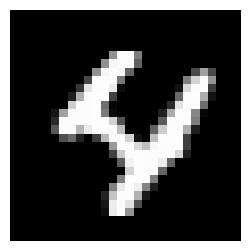

In [9]:
# Visualizar una imagen
random_idx = random.randint(0, len(train_batches)-1)
img_batch = train_batches[random_idx]
fig = plt.figure(figsize=(3,3))
plt.imshow(img_batch.squeeze(), cmap='gray')
plt.axis("off")
plt.show()

In [10]:
# Configuración de CPU o GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## 3. Definir modelo

### Discriminador
Arquitectura del discriminador convolucional.   
**Entrada y Salida**
- La entrada del discriminador es una imagen de (num_batches,1,28,28).
- La salida es un valor de probabilidad.  

**Arquitectura**  
- Utilizar capas convolucionales `Conv2d` con `strides=2` en lugar de capas `MaxPooling` para reducir el tamaño de la imagen.
- Utilizar `BatchNorm2d` en todas las capas del discriminador excepto en la entrada del discriminador.
- Utilizar la función de activación `LeakyReLU` con una pendiente de **0.2** en las capas intermedias exepto en la salida.
- Eliminar capas completamente conectadas.
- Utilizar la función de activación `Sigmoid` en la salida para regresar valores en el rango de  0 y 1.  

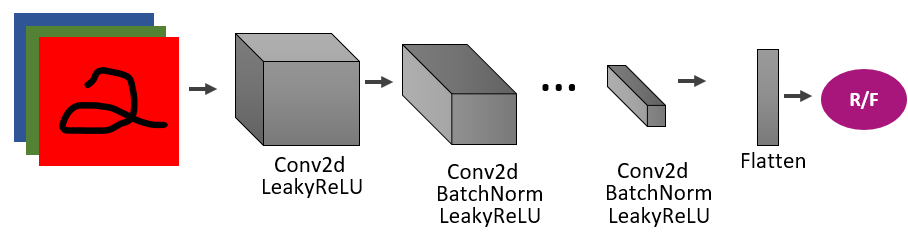

In [11]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self, channels_img, hidden_units):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=channels_img, out_channels=hidden_units, kernel_size=3, stride=2, padding=1),#(1,28,28)->(32,14,14)
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1),#(32,14,14)->(64,7,7)
            nn.BatchNorm2d(hidden_units*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=2, padding=1),#(64,7,7)->(128,4,4)
            nn.BatchNorm2d(hidden_units*4),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=1),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = self.model(x)
        return x

In [12]:
# Configurar el modelo con los parámetros de entrada
discriminator = Discriminator(channels_img=1, hidden_units=32)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=2048, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [13]:
# Probar discriminador con entrada dummy
dummy_x = torch.rand([1,1,28,28]).to(device)
print(f"Tamaño del vector de entrada del discriminador: {dummy_x.size()}")

dummy_out = discriminator(dummy_x).detach()
print(f"Salida del discriminador: {dummy_out}")

Tamaño del vector de entrada del discriminador: torch.Size([1, 1, 28, 28])
Salida del discriminador: tensor([[0.3033]], device='cuda:0')


### Generador

Arquitectura del generador convolucional.   
**Entrada y Salida**
- La entrada del generador es una vector de ruido con una distribución normal de dimesión (num_batches,LATENT_SPACE).
- La salida es un imagen de dimensión (num_batches,1,28,28)

**Arquitectura**  
- Utilizar capas convolucionales transpuestas `ConvTranspose2d` con `strides=2` para aumentar el tamaño de la imagen.
- Utilizar `BatchNorm2d` en todas las capas del generador excepto en la salida.
- Utilizar la función de activación `ReLU` en las capas intermedias exepto en la salida.
- Utilizar la función de activación `Sigmoid` en la salida para regresar valores en el rango de  [0, 1] o `Tanh` si las entradas estan en el rango de [-1,1].  

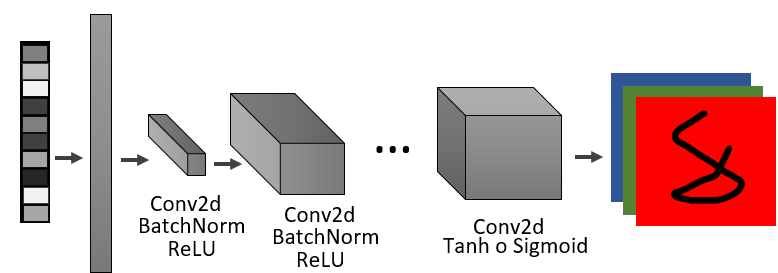

In [14]:
# Definición de la clase Generador
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units
        self.block1 = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=7*7*hidden_units*4))
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_units*4, out_channels=hidden_units*2, kernel_size=3, stride=2, padding=1,output_padding=1), #(256,7,7)->(128,14,14)
            nn.BatchNorm2d(hidden_units*2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units*2, out_channels=hidden_units, kernel_size=3, stride=1, padding=1), #(128,14,14)-> (64,14,14)
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),#(64,14,14)-> (1,28,28)
            nn.Tanh()
        )

    def forward(self,x):
        x = self.block1(x)
        # reshape from flatten to hidden_units,h,w
        x = torch.reshape(x, (-1, self.hidden_units*4,7,7))
        x = self.block2(x)
        return x

In [15]:
LATENT_DIM = 100 # Dimensión del vector en el espacio de latencia

In [16]:
# Configurar el modelo con los parámetros de entrada
generator = Generator(latent_dim=LATENT_DIM, hidden_units=64)
generator.to(device)

Generator(
  (block1): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Tanh()
  )
)

In [17]:
# Probar generador con entrada dummy
dummy_x = torch.rand([1,100]).to(device)
print(f"Tamaño del vector de entrada del generador: {dummy_x.size()}")

dummy_img = generator(dummy_x).cpu().detach()
print(f"Tamaño de la salida del generador: {dummy_img.shape}")

Tamaño del vector de entrada del generador: torch.Size([1, 100])
Tamaño de la salida del generador: torch.Size([1, 1, 28, 28])


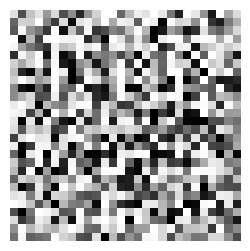

In [18]:
# Visualizar una imagen
fig = plt.figure(figsize=(3,3))
plt.imshow(dummy_img.squeeze(), cmap='gray')
plt.axis("off")
plt.show()

## 5. Definir función de costo y optimizador

In [19]:
def discriminator_loss(real_out, fake_out,smoothing_factor = 0.9):
    '''
    Input:
    - real_out. Predicciones de imágenes reales
    - fake_ out. Predicciones de imágenes falsas
    -smoothing_factor. Factor de ruido en la entrada del discriminador
    '''
    real_loss = F.binary_cross_entropy(real_out, torch.ones_like(real_out)*smoothing_factor)
    fake_loss = F.binary_cross_entropy(fake_out, torch.zeros_like(fake_out))
    total_loss = (real_loss + fake_loss)/2
    return total_loss

In [20]:
def generator_loss(fake_out):
    '''
    Input:
    - fake_ out. Predicciones de imágenes falsas
    '''
    gen_loss = F.binary_cross_entropy(fake_out, torch.ones_like(fake_out))
    return gen_loss

In [21]:
# Definir momentum y factor de aprendizaje de optimizador Adam
lr = 0.0002
betas = (0.5, 0.999)
generator_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
discriminator_opt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

## 5. Entrenamiento

In [22]:
def generate_noise_vectors(sample_size,latent_dim):
    '''
    Input:
    - sample_size. Tamaño de las muestras
    - latent_dim. Dimesión del vector
    '''
    noise_vector = torch.randn(sample_size,latent_dim)
    return noise_vector

In [23]:
# Generar vectores para imágenes de prueba
num_images_test = 25
torch.manual_seed(42)
noise_test = generate_noise_vectors(num_images_test,LATENT_DIM)
noise_test.shape

torch.Size([25, 100])

In [24]:
def show_grid(images, epoch, rows = int(math.sqrt(num_images_test))):
    num = images.size(0)
    fig = plt.figure(figsize= (5,5))

    for i in range(1, num+1):
        fig.add_subplot(rows, rows, i)
        plt.axis('off')
        plt.imshow(images[i-1].squeeze(), cmap = 'gray')

    plt.savefig('./image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return

In [25]:
EPOCHS = 30 # Número de épocas

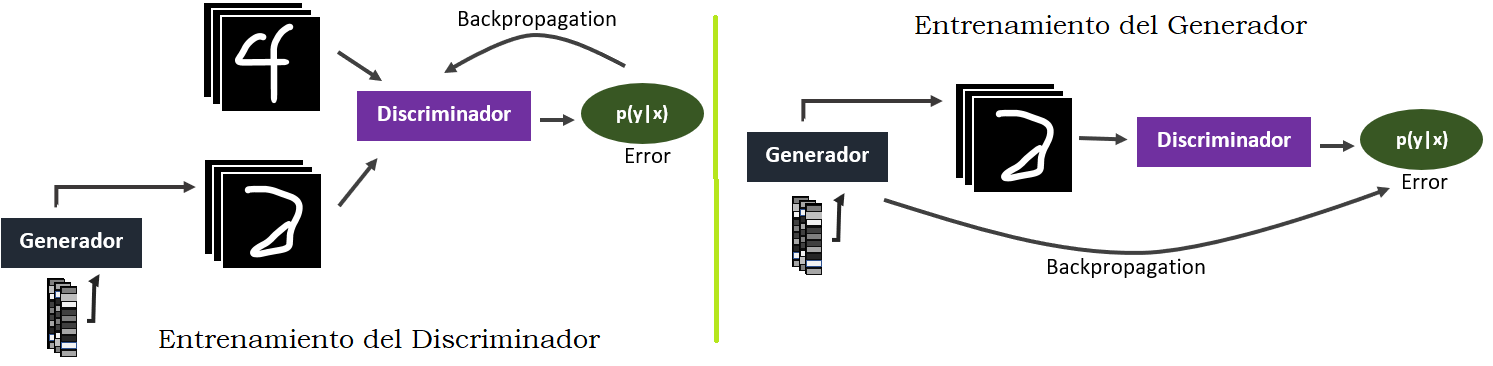

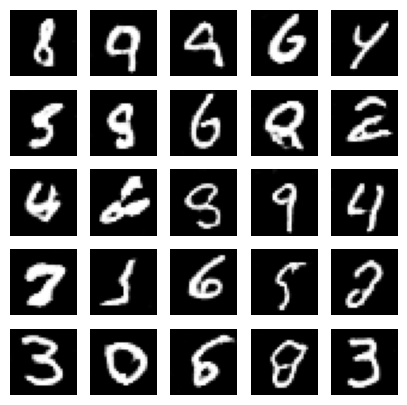

Epoch: 26
--------
Train Epoch: 26 [0/60000 (0%)]	G-Loss: 2.098403 D-Loss: 0.266743
Train Epoch: 26 [38400/60000 (64%)]	G-Loss: 1.580549 D-Loss: 0.320480
Epoch: 27
--------
Train Epoch: 27 [0/60000 (0%)]	G-Loss: 1.329944 D-Loss: 0.327093
Train Epoch: 27 [38400/60000 (64%)]	G-Loss: 3.003336 D-Loss: 0.466548
Epoch: 28
--------
Train Epoch: 28 [0/60000 (0%)]	G-Loss: 1.808094 D-Loss: 0.273119
Train Epoch: 28 [38400/60000 (64%)]	G-Loss: 2.715074 D-Loss: 0.356033
Epoch: 29
--------
Train Epoch: 29 [0/60000 (0%)]	G-Loss: 2.467755 D-Loss: 0.295981
Train Epoch: 29 [38400/60000 (64%)]	G-Loss: 1.900466 D-Loss: 0.299809


In [26]:
# training mode
generator.train()
discriminator.train()

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n--------" )
    for batch, (real_images, _) in enumerate(train_dataloader):
        ## ---------------------- Entrenamiento del Discriminador ----------------------
        discriminator_opt.zero_grad()
        cur_batch_size = len(real_images)  # Tamaño "real" del batch
        real_images = real_images.to(device)
        # Generar imágenes falsas
        noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
        fake_images = generator(noise)
        # Predicción en imágenes reales
        real_preds = discriminator(real_images)
        # Predicción en imágenes falsas
        fake_preds = discriminator(fake_images.detach())
        # Se calcula la función de costo del discriminador
        disc_loss = discriminator_loss(real_preds, fake_preds)
        # Backpropagation para actualizar parámetros del discriminador
        disc_loss.backward()
        discriminator_opt.step()

        ## ---------------------- Entrenamiento del Generador ----------------------
        # Generar imágenes falsas
        noise = generate_noise_vectors(cur_batch_size,LATENT_DIM).to(device)
        generated_images = generator(noise)
        generator_opt.zero_grad()
        # Predicción en imágenes falsas
        fake_preds = discriminator(generated_images)
        # Se calcula la función de costo del generador
        gen_loss = generator_loss(fake_preds)
        # Backpropagation para actualizar parámetros del generador
        gen_loss.backward()
        generator_opt.step()

        # Visualizar progreso del entrenamiento
        if batch % 300 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tG-Loss: {:.6f} D-Loss: {:.6f}'.format(
                epoch, batch * len(real_images), len(train_dataloader.dataset),
                100. * batch / len(train_dataloader), gen_loss.item(), disc_loss.item()))


    # Visualizar imágenes generadas cada cierto tiempo
    if epoch%5 ==0:
        display.clear_output(wait=True)
        test_imgs = generator(noise_test.to(device)).detach()
        test_imgs = test_imgs.cpu()
        show_grid(test_imgs,epoch)


In [27]:
# Crear GIF con imágenes generadas
images = list()
filenames = glob.glob('./image*.png')
filenames = sorted(filenames)
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./dcgan_mnist.gif', images) # Guardar GIF

<ipython-input-27-985f21525694>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
